# 信用情報の学習

### 【問題1】コンペティション内容の確認

・何を学習し、何を予測するのか

⇒クライアントの電話会社や取引情報などのさまざまな代替データを利用して、クライアントの返済能力を予測する。


・どのようなファイルを作りKaggleに提出するか

⇒SK_ID_CURR テストセットのそれぞれについて、TARGET変数の確率を予測する必要があります。ファイルにはヘッダーが含まれ、次の形式である必要がある。

-------------------------

SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.

-------------------------


・提出されたものはどういった指標値で評価されるのか

⇒予測された確率と観察されたターゲットの間のROC曲線の下の領域で評価される。
良いモデルの場合は真陽性率の方が早く上がるので、上に早く進みます。悪いモデルの場合は偽陽性率の方が早く上がるので、右に早く進む。


### 【問題2】学習と検証

In [1]:
###################
#インポート
###################

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

###################
#ＣＳＶ表示数の変更
###################

#pd.set_option('display.max_rows', None)    #行（index)全表示
pd.set_option("display.max_columns", None) #列（colums)全表示
#pd.set_option('display.max_rows', 10)       #行（index)の最大表示数を10に変更
#pd.set_option("display.max_columns", 10)  #列（colums)の最大表示数を10に変更

###################
#ＣＳＶインポート
###################

df = pd.read_csv("application_train.csv") #CSVをインポート
display(df) #インポートしたデータを出力



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [2]:
###################
#ディスクリプションＣＳＶインポート
###################

pd.set_option('display.max_rows', None)    #行（index)全表示

df_description = pd.read_csv("description(application_train).csv", encoding="shift-jis") #ディスクリプションCSVをインポート
display(df_description) #インポートしたデータを出力


,Unnamed: 0,Row,説明,スペシャル
0,1,SK_ID_CURR,サンプル内のローンのID,NaN
1,2,TARGET,対象変数（1：支払い困難な顧客：サンプル中のローンの最初のY回のうち少なくとも1回でX日以上...,NaN
2,5,NAME_CONTRACT_TYPE,ローンが現金かリボルビングかの識別,NaN
3,6,CODE_GENDER,顧客の性別,NaN
4,7,FLAG_OWN_CAR,顧客が自動車を所有しているかどうかのフラグ,NaN
5,8,FLAG_OWN_REALTY,家やアパートを所有しているかどうかのフラグ,NaN
6,9,CNT_CHILDREN,顧客の子供の数,NaN
7,10,AMT_INCOME_TOTAL,お客様の収入,NaN
8,11,AMT_CREDIT,ローンの債権額,NaN
9,12,AMT_ANNUITY,ローンの年金額,NaN


In [3]:

#----欠損値の削除工程----
pd.set_option('display.max_rows', 10)       #行（index)の最大表示数を10に変更
pd.set_option("display.max_columns", None) #列（colums)全表示

#1000以上データがあるカラムは残してそれ以外はaxis=1の列を削除する
del_missing_columns = df.dropna(thresh=1000, axis = 1) 

#インデックスに一つでも欠損値があれば削除する。dropnaはデフォルトがaxis=0
del_missing_columns_deleteindex = del_missing_columns.dropna(how = "any" ) 

#NULL値が含まれているかどうかを確認
null_cols = [col for col in del_missing_columns_deleteindex.columns if del_missing_columns_deleteindex[col].isnull().sum() > 0]
print(null_cols)


#display(del_missing_columns[MiscFeature]) #del_missing_columnsのMiscFeatureカラムを表示させてみる

#欠損値を完全削除したDFのインデックスをリセット
del_missing_columns_align_index = del_missing_columns_deleteindex.reset_index() # del_missing_columns_deleteindexはインデックスが通し番号でない為デフォルトのインデックスにリセット
display(del_missing_columns_align_index)





[]


,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,71,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,463500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.009657,-15406,-892,-341.0,-4176,22.0,1,1,0,1,0,0,Laborers,2.0,2,2,MONDAY,18,0,0,0,0,0,0,Business Entity Type 3,0.270766,0.707126,0.597192,0.1464,0.1291,0.9861,0.8096,0.1080,0.04,0.0345,0.3333,0.3750,0.0000,0.1194,0.0933,0.0000,0.0000,0.1492,0.1340,0.9861,0.8171,0.1090,0.0403,0.0345,0.3333,0.3750,0.0000,0.1304,0.0972,0.0000,0.0000,0.1478,0.1291,0.9861,0.8121,0.1087,0.04,0.0345,0.3333,0.3750,0.0000,0.1214,0.0949,0.0000,0.0000,reg oper account,block of flats,0.1324,"Stone, brick",No,2.0,1.0,2.0,1.0,-2053.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,124,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,198000.0,Family,Working,Secondary / secondary special,Separated,House / apartment,0.018850,-16282,-4375,-762.0,-1494,8.0,1,1,0,1,0,0,Laborers,2.0,2,2,TUESDAY,11,0,0,0,0,0,0,Self-employed,0.647045,0.746486,0.739412,0.0928,0.1000,0.9801,0.7280,0.0463,0.00,0.2069,0.1667,0.2083,0.0437,0.0756,0.0903,0.0000,0.0000,0.0945,0.1038,0.9801,0.7387,0.0467,0.0000,0.2069,0.1667,0.2083,0.0447,0.0826,0.0941,0.0000,0.0000,0.0937,0.1000,0.9801,0.7316,0.0466,0.00,0.2069,0.1667,0.2083,0.0445,0.0770,0.0919,0.0000,0.0000,reg oper spec account,block of flats,0.0710,Panel,No,6.0,0.0,6.0,0.0,-1782.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,152,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,675000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.031329,-11375,-2311,-180.0,-2009,4.0,1,1,0,1,0,0,Managers,2.0,2,2,MONDAY,13,0,0,0,0,0,0,Trade: type 7,0.674832,0.616156,0.673830,0.5845,0.4570,0.9945,0.9252,0.3468,0.60,0.2414,0.9167,0.5000,0.2847,0.4287,0.7187,0.2201

### 【問題2】学習と検証

count      8602
mean     222872
std      141420
min       33750
25%      135000
50%      193500
75%      270000
max     4500000
Name: AMT_INCOME_TOTAL, dtype: float64

count    8602
mean    -2976
std      1516
min     -6551
25%     -4283
50%     -3197
75%     -1683
max        -1
Name: DAYS_ID_PUBLISH, dtype: float64

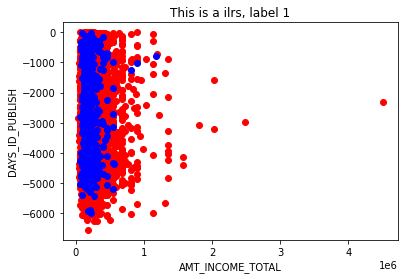

In [4]:

#-------------２つの特徴量を選ぶ-----------


#　AMT_INCOME_TOTAL(お客様の収入) と　DAYS_ID_PUBLISH(申し込みの何日前に、ローンを申し込む際の身分証明書を変更したか)　を使って学習する
pd.options.display.float_format = '{:.0f}'.format #小数点を表示しない



#del_missing_columns_align_index["AMT_INCOME_TOTAL"の平均標準偏差等を表示
display(del_missing_columns_align_index["AMT_INCOME_TOTAL"].describe())
#del_missing_columns_align_index["DAYS_ID_PUBLISH"の平均標準偏差等を表示
display(del_missing_columns_align_index["DAYS_ID_PUBLISH"].describe())

#散布図表示の（X,y）を準備する

#返済者の　AMT_INCOME_TOTAL×DAYS_ID_PUBLISH　
X_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'AMT_INCOME_TOTAL' ] ] #返済者のAMT_INCOME_TOTAL
y_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'DAYS_ID_PUBLISH' ] ] #返済者のDAYS_ID_PUBLISH
#破産者の　AMT_INCOME_TOTAL×DAYS_ID_PUBLISH　
X_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'AMT_INCOME_TOTAL' ] ] #破産者のAMT_INCOME_TOTAL
y_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'DAYS_ID_PUBLISH' ] ] #破産者のDAYS_ID_PUBLISH

plt.title("This is a ilrs, label 1")
plt.xlabel("AMT_INCOME_TOTAL")
plt.ylabel("DAYS_ID_PUBLISH")
plt.scatter(X_0, y_0, c='red')

plt.scatter(X_1, y_1, c='blue')
plt.show()


In [5]:
#-------------データを分割-----------

#ランダムにデータ分割するモジュール
from sklearn.model_selection import train_test_split

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 欠損値カットデータから特徴量と目的変数を取り出したDFを用意する
X = del_missing_columns_align_index.loc[ :  ,  [ 'AMT_INCOME_TOTAL' ,  'DAYS_ID_PUBLISH' ] ]
y = del_missing_columns_align_index.loc[ :  ,  [ 'TARGET' ] ]


# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

display(X_train)
display(y_train)


,AMT_INCOME_TOTAL,DAYS_ID_PUBLISH
1489,270000,-1905
812,157500,-3043
1882,225000,-3608
6813,135000,-2273
3464,202500,-4215
...,...,...
5734,211500,-2597
5191,810000,-911
5390,132750,-4114
860,157500,-584


,TARGET
1489,0
812,0
1882,0
6813,0
3464,0
...,...
5734,0
5191,0
5390,0
860,0


In [6]:
#-------------X_train, X_testを標準化する-----------

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 標準化をする（訓練用データで.fitを行う）
scaler.fit(X_train)

# 標準化をする（訓練用、検証用双方で.transformを行う）
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

display(X_train_transform)
display(X_test_transform)

array([[ 0.3243495 ,  0.70433496],
       [-0.45199164, -0.04945606],
       [ 0.01381305, -0.42370204],
       ...,
       [-0.62278669, -0.75886747],
       [-0.45199164,  1.57934194],
       [ 0.63488596,  1.95888698]])

array([[ 0.01381305, -1.13178869],
       [-0.23461612,  0.2433169 ],
       [ 0.07592034, -1.1463611 ],
       ...,
       [-0.91779632, -0.66282204],
       [-0.29672341, -1.09668243],
       [-0.60725987,  0.0267179 ]])

In [7]:
# #-------------線形回帰による学習-----------

# # sklearnのから各種モデルをimportする
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error


# # データを確認
# # display(X_train_transform) #標準化した訓練用特徴量DF
# # display(X_test_transformed) #標準化した検証用特徴量DF
# # display(y_train) #訓練用目的変数DF
# # display(y_test) #検証用目的変数DF

# # インスタンス作成から学習
# linear_reg = LinearRegression() #LinearRegressionをインスタンス化
# linear_reg.fit(X_train_transform, y_train) #LinearRegressionのfitメソッドを呼び出し

# # テストデータを代入して目的変数を推定
# y_pred = linear_reg.predict(X_test_transformed)
# display(y_pred)

# # 平均二乗誤差（標準偏差、ばらつき、MSE）を求める
# print("MSE : {}".format(mean_squared_error(y_test, y_pred)))

# #二乗平均平方根誤差 (RMSE)を求める
# print("RMSE : {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))


# # # 可視化
# # plt.title("predicted SalePrice, GrLivArea")
# # plt.xlabel("GrLivArea [square feet]")
# # plt.ylabel("SalePrice [$]")
# # plt.scatter(X_test["GrLivArea"], y_pred)
# # plt.show()

# # plt.title("predicted SalePrice, YearBuilt")
# # plt.xlabel("YearBuilt")
# # plt.ylabel("SalePrice [$]")
# # plt.scatter(X_test["YearBuilt"], y_pred)
# # plt.show()

In [8]:
#-------------最近傍法（k-nearest neighbors, k-nn）による学習-----------
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighborsを決めたneighを定義する
neigh = KNeighborsClassifier(n_neighbors=3) 

#データを確認
# display(X_train_transform) #標準化した訓練用特徴量DF
# display(X_test_transform) #標準化した検証用特徴量DF
# display(y_train) #訓練用目的変数DF
# display(y_test) #検証用目的変数DF



In [9]:
#-------------検証データを代入して予測データを作成-----------

#.fitメソッドでトレーニングデータセットからk最近傍分類器を適合させる。
neigh.fit(X_train_transform, y_train)

#検証データ(X_test_transform)を引数としてクスラベル予測データを出力
y_test_pred = neigh.predict(X_test_transform) #neigh.predict(特徴量ndarray)で予測データを作成
display(y_test_pred)#予測データ

#テストデータXの確率推定値を返す。
#print(neigh.predict_proba(X_test_transform))

<ipython-input-9-092c322347db>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train_transform, y_train)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [10]:
#-------------最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 について
from sklearn import metrics 
print("・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について")
print("\n")

#print(y_test.shape)
#print(y_test_pred.shape)

# 評価する関数を作成する
def evaluate(y_test, y_test_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_test_pred) #正解率
    precision = metrics.precision_score(y_test, y_test_pred) #適合率
    recall = metrics.recall_score(y_test, y_test_pred) #再現率
    f1 = metrics.f1_score(y_test, y_test_pred) #F値
    confusion = metrics.confusion_matrix(y_test, y_test_pred)
    
    return acc, precision, recall, f1, confusion

acc, precision, recall, f1, confusion = evaluate(y_test, y_test_pred)
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(acc,precision,recall,f1,confusion))


・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について


acc : 0.9307298930729893
precision : 0.058823529411764705
recall : 0.01680672268907563
f1 : 0.026143790849673203
confusion matrix 
 [[2000   32]
 [ 117    2]]


ROCの数 : 3
[0.         0.01574803 1.        ]
[0.         0.01680672 1.        ]
[2 1 0]


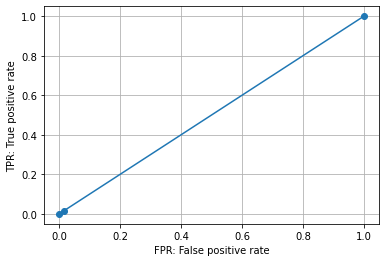

In [11]:
#-------------ROC曲線を算出-----------

from sklearn.metrics import roc_curve

#ROC曲線を算出
roc = roc_curve(y_test, y_test_pred,drop_intermediate=False) #drop_intermediateはROC曲線の形状に影響しない点を省略するかどうか

# <class 'tuple'>
print("ROCの数 : {}".format(len(roc)))

# FPR（偽陽性率）、TPR（真陽性率）、thresholds（閾値）を算出
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred) 

print(fpr)
print(tpr)
print(thresholds)

# fprを横軸、tprを縦軸にプロットしたものをROC曲線
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
#plt.savefig('data/dst/sklearn_roc_curve.png') #グラフを保存したい時に使う

In [12]:
#-------------ROC-AUCスコアの算出-----------

from sklearn.metrics import roc_auc_score
import numpy as np

print("OC-AUCスコア : {}".format(roc_auc_score(y_test, y_test_pred)))


OC-AUCスコア : 0.5005293455965063


### 【問題3】テストデータに対する推定
テストデータ（application_test.csv）に対して推定を行う

In [13]:
###################
#ＣＳＶ表示数の変更
###################

pd.set_option('display.max_rows', 10)       #行（index)の最大表示数を10に変更
pd.set_option("display.max_columns", None)   #列（colums)全表示


###################
#テストデータＣＳＶインポート
###################

df_testdata = pd.read_csv("application_test.csv") #CSVをインポート
display(df_testdata) #インポートしたデータを出力



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000,568800,20560,450000,Unaccompanied,Working,Higher education,Married,House / apartment,0,-19241,-2329,-5170,-812,nan,1,1,0,1,0,1,NaN,2,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,1,1,0,0,0,1,nan,nan,nan,0,0,nan,nan,nan,0,nan,nan,0,0,1,nan,nan,nan,0,0,nan,nan,nan,0,nan,nan,0,0,1,nan,nan,nan,0,0,nan,nan,nan,0,nan,nan,NaN,block of flats,0,"Stone, brick",No,0,0,0,0,-1740,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100005,Cash loans,M,N,Y,0,99000,222768,17370,180000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0,-18064,-4469,-9118,-1623,nan,1,1,0,1,0,0,Low-skill Laborers,2,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,1,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,100013,Cash loans,M,Y,Y,0,202500,663264,69777,630000,NaN,Working,Higher education,Married,House / apartment,0,-20038,-4458,-2175,-3503,5,1,1,0,1,0,0,Drivers,2,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,nan,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0,0,0,0,-856,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
3,100028,Cash loans,F,N,Y,2,315000,1575000,49018,1575000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0,-13976,-1866,-2000,-4208,nan,1,1,0,1,1,0,Sales staff,4,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,reg oper account,block of flats,0,Panel,No,0,0,0,0,-1805,0,1,0,

In [14]:
#----テストデータ欠損値の削除工程----
pd.set_option('display.max_rows', 10)       #行（index)の最大表示数を10に変更
pd.set_option("display.max_columns", None) #列（colums)全表示

#1000以上データがあるカラムは残してそれ以外はaxis=1の列を削除する、またインデックスに一つでも欠損値があれば削除する。dropnaはデフォルトがaxis=0
df_test_del_miss = (df_testdata.dropna(thresh=1000, axis = 1)).dropna(how = "any" ) 

#NULL値が含まれているかどうかを確認
null_cols = [col for col in df_test_del_miss.columns if df_test_del_miss[col].isnull().sum() > 0]
print(null_cols)

#display(del_missing_columns[MiscFeature]) #del_missing_columnsのMiscFeatureカラムを表示させてみる

#欠損値を完全削除したDFのインデックスをリセット
df_test_del_miss_index_reset = df_test_del_miss.reset_index() # del_missing_columns_deleteindexはインデックスが通し番号でない為デフォルトのインデックスにリセット

#欠損値を完全削除したDFから　AMT_INCOME_TOTAL　と　DAYS_ID_PUBLISHをスライスする。
df_test_AMT_INCOME_TOTAL_DAYS_ID_PUBLISH = df_test_del_miss_index_reset.loc[ :  ,  [ 'AMT_INCOME_TOTAL' ,  'DAYS_ID_PUBLISH' ] ]

display(df_test_AMT_INCOME_TOTAL_DAYS_ID_PUBLISH)#★☆これがテストデータ



[]


,AMT_INCOME_TOTAL,DAYS_ID_PUBLISH
0,180000,-4044
1,225000,-1721
2,180000,-4134
3,225000,-4436
4,202500,-1476
...,...,...
1734,112500,-2512
1735,387000,-3976
1736,450000,-2263
1737,202500,-2842


In [15]:
#-------------検証データを代入して予測データを作成-----------

#検証データ(X_test_transform)を引数としてクスラベル予測データを出力
y_test_pred = neigh.predict(df_test_AMT_INCOME_TOTAL_DAYS_ID_PUBLISH) #neigh.predict(特徴量ndarray)で予測データを作成
display(y_test_pred)#予測データ

#テストデータXの確率推定値を返す。
#print(neigh.predict_proba(X_test_transform))



array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### 【問題4】特徴量エンジニアリング

#-------------特徴量エンジニアリング（精度を上げる試作）を行う-----------


・パターン２　
・パターン３　
・パターン４　
・パターン５　


count      8602
mean     222872
std      141420
min       33750
25%      135000
50%      193500
75%      270000
max     4500000
Name: AMT_INCOME_TOTAL, dtype: float64

count     8602
mean    -14189
std       3259
min     -24835
25%     -16300
50%     -13884
75%     -11664
max      -7715
Name: DAYS_BIRTH, dtype: float64

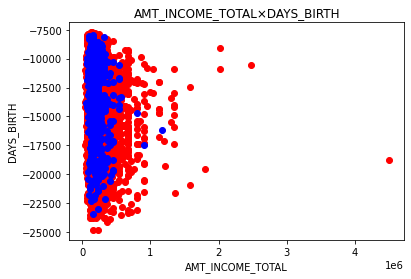

In [23]:
#・パターン１　AMT_INCOME_TOTAL　×　DAYS_BIRTH

pd.options.display.float_format = '{:.0f}'.format #小数点を表示しない

#del_missing_columns_align_index["AMT_INCOME_TOTAL"の平均標準偏差等を表示
display(del_missing_columns_align_index["AMT_INCOME_TOTAL"].describe())
#del_missing_columns_align_index["DAYS_BIRTH"の平均標準偏差等を表示
display(del_missing_columns_align_index["DAYS_BIRTH"].describe())

#散布図表示の（X,y）を準備する

#返済者の　AMT_INCOME_TOTAL×DAYS_BIRTH
X_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'AMT_INCOME_TOTAL' ] ] #返済者のAMT_INCOME_TOTAL
y_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'DAYS_BIRTH' ] ] #返済者のDAYS_BIRTH
#破産者の　AMT_INCOME_TOTAL×DAYS_BIRTH
X_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'AMT_INCOME_TOTAL' ] ] #破産者のAMT_INCOME_TOTAL
y_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'DAYS_BIRTH' ] ] #破産者のDAYS_BIRTH

plt.title("AMT_INCOME_TOTAL×DAYS_BIRTH")
plt.xlabel("AMT_INCOME_TOTAL")
plt.ylabel("DAYS_BIRTH")
plt.scatter(X_0, y_0, c='red')

plt.scatter(X_1, y_1, c='blue')
plt.show()



In [24]:
#-------------データを分割-----------

#ランダムにデータ分割するモジュール
from sklearn.model_selection import train_test_split

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 欠損値カットデータから特徴量と目的変数を取り出したDFを用意する
X = del_missing_columns_align_index.loc[ :  ,  [ 'AMT_INCOME_TOTAL' ,  'DAYS_BIRTH' ] ]
y = del_missing_columns_align_index.loc[ :  ,  [ 'TARGET' ] ]


# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

display(X_train)
display(y_train)


,AMT_INCOME_TOTAL,DAYS_BIRTH
1489,270000,-9262
812,157500,-10372
1882,225000,-20120
6813,135000,-10380
3464,202500,-13229
...,...,...
5734,211500,-9977
5191,810000,-17359
5390,132750,-13395
860,157500,-10018


,TARGET
1489,0
812,0
1882,0
6813,0
3464,0
...,...
5734,0
5191,0
5390,0
860,0


In [18]:
#-------------X_train, X_testを標準化する-----------

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 標準化をする（訓練用データで.fitを行う）
scaler.fit(X_train)

# 標準化をする（訓練用、検証用双方で.transformを行う）
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

display(X_train_transform)
display(X_test_transform)

array([[ 0.3243495 ,  1.50834379],
       [-0.45199164,  1.16865784],
       [ 0.01381305, -1.81445806],
       ...,
       [-0.62278669,  0.24354916],
       [-0.45199164,  1.27699012],
       [ 0.63488596,  1.15396872]])

array([[ 0.01381305,  0.03667736],
       [-0.23461612,  1.18181685],
       [ 0.07592034, -2.23340407],
       ...,
       [-0.91779632,  0.76562505],
       [-0.29672341, -0.42756011],
       [-0.60725987,  1.19834211]])

In [25]:
#-------------最近傍法（k-nearest neighbors, k-nn）による学習-----------
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighborsを決めたneighを定義する
neigh = KNeighborsClassifier(n_neighbors=3) 

#データを確認
# display(X_train_transform) #標準化した訓練用特徴量DF
# display(X_test_transform) #標準化した検証用特徴量DF
# display(y_train) #訓練用目的変数DF
# display(y_test) #検証用目的変数DF



In [20]:
#-------------検証データを代入して予測データを作成-----------

#.fitメソッドでトレーニングデータセットからk最近傍分類器を適合させる。
neigh.fit(X_train_transform, y_train)

#検証データ(X_test_transform)を引数としてクスラベル予測データを出力
y_test_pred = neigh.predict(X_test_transform) #neigh.predict(特徴量ndarray)で予測データを作成
display(y_test_pred)#予測データ

#テストデータXの確率推定値を返す。
#print(neigh.predict_proba(X_test_transform))

<ipython-input-20-092c322347db>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train_transform, y_train)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [26]:
#-------------最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 について
from sklearn import metrics 
print("・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について")
print("\n")

#print(y_test.shape)
#print(y_test_pred.shape)

# 評価する関数を作成する
def evaluate(y_test, y_test_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_test_pred) #正解率
    precision = metrics.precision_score(y_test, y_test_pred) #適合率
    recall = metrics.recall_score(y_test, y_test_pred) #再現率
    f1 = metrics.f1_score(y_test, y_test_pred) #F値
    confusion = metrics.confusion_matrix(y_test, y_test_pred)
    
    return acc, precision, recall, f1, confusion

acc, precision, recall, f1, confusion = evaluate(y_test, y_test_pred)
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(acc,precision,recall,f1,confusion))


・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について


acc : 0.9311947931194793
precision : 0.0
recall : 0.0
f1 : 0.0
confusion matrix 
 [[2003   29]
 [ 119    0]]


count   8602
mean      11
std       12
min        0
25%        4
50%        8
75%       14
max       65
Name: OWN_CAR_AGE, dtype: float64

count     8602
mean     -2299
std       2077
min     -14375
25%      -3132
50%      -1680
75%       -817
max         -4
Name: DAYS_EMPLOYED, dtype: float64

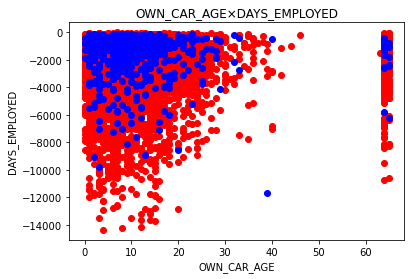

In [27]:
#・パターン２　OWN_CAR_AGE(お客様の車の年式)　×　DAYS_EMPLOYED(申し込みの何日前に現在の仕事を始めたか)

pd.options.display.float_format = '{:.0f}'.format #小数点を表示しない

#del_missing_columns_align_index["OWN_CAR_AGE"の平均標準偏差等を表示
display(del_missing_columns_align_index["OWN_CAR_AGE"].describe())
#del_missing_columns_align_index["DAYS_EMPLOYED"の平均標準偏差等を表示
display(del_missing_columns_align_index["DAYS_EMPLOYED"].describe())

#散布図表示の（X,y）を準備する

#返済者の　OWN_CAR_AGE×DAYS_EMPLOYED
X_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'OWN_CAR_AGE' ] ] #返済者のOWN_CAR_AGE
y_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'DAYS_EMPLOYED' ] ] #返済者のDAYS_EMPLOYED
#破産者の　OWN_CAR_AGE×DAYS_EMPLOYED
X_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'OWN_CAR_AGE' ] ] #破産者のOWN_CAR_AGE
y_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'DAYS_EMPLOYED' ] ] #破産者のDAYS_EMPLOYED

plt.title("OWN_CAR_AGE×DAYS_EMPLOYED")
plt.xlabel("OWN_CAR_AGE")
plt.ylabel("DAYS_EMPLOYED")
plt.scatter(X_0, y_0, c='red')

plt.scatter(X_1, y_1, c='blue')
plt.show()


In [28]:
#-------------データを分割-----------

#ランダムにデータ分割するモジュール
from sklearn.model_selection import train_test_split

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 欠損値カットデータから特徴量と目的変数を取り出したDFを用意する
X = del_missing_columns_align_index.loc[ :  ,  [ 'OWN_CAR_AGE' ,  'DAYS_EMPLOYED' ] ]
y = del_missing_columns_align_index.loc[ :  ,  [ 'TARGET' ] ]


# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

display(X_train)
display(y_train)



,OWN_CAR_AGE,DAYS_EMPLOYED
1489,0,-411
812,38,-700
1882,4,-1032
6813,14,-120
3464,14,-1984
...,...,...
5734,4,-1464
5191,2,-1323
5390,12,-3508
860,14,-1099


,TARGET
1489,0
812,0
1882,0
6813,0
3464,0
...,...
5734,0
5191,0
5390,0
860,0


In [29]:
#-------------X_train, X_testを標準化する-----------

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 標準化をする（訓練用データで.fitを行う）
scaler.fit(X_train)

# 標準化をする（訓練用、検証用双方で.transformを行う）
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

display(X_train_transform)
display(X_test_transform)



array([[-0.89817879,  0.89940029],
       [ 2.15865678,  0.76092277],
       [-0.57640663,  0.60184133],
       ...,
       [ 0.0671377 , -0.58456123],
       [ 0.22802379,  0.56973754],
       [ 0.71068204,  0.97750353]])

array([[-0.3350775 ,  0.78104753],
       [-0.17419142,  0.58459153],
       [ 0.14758075,  0.68521534],
       ...,
       [-0.17419142,  0.81650544],
       [ 0.54979595,  0.80500558],
       [ 0.30846683,  0.91952505]])

In [30]:
#-------------最近傍法（k-nearest neighbors, k-nn）による学習-----------
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighborsを決めたneighを定義する
neigh = KNeighborsClassifier(n_neighbors=3) 

#データを確認
# display(X_train_transform) #標準化した訓練用特徴量DF
# display(X_test_transform) #標準化した検証用特徴量DF
# display(y_train) #訓練用目的変数DF
# display(y_test) #検証用目的変数DF

In [31]:
#-------------検証データを代入して予測データを作成-----------

#.fitメソッドでトレーニングデータセットからk最近傍分類器を適合させる。
neigh.fit(X_train_transform, y_train)

#検証データ(X_test_transform)を引数としてクスラベル予測データを出力
y_test_pred = neigh.predict(X_test_transform) #neigh.predict(特徴量ndarray)で予測データを作成
display(y_test_pred)#予測データ

#テストデータXの確率推定値を返す。
#print(neigh.predict_proba(X_test_transform))


<ipython-input-31-092c322347db>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train_transform, y_train)


array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [32]:
#-------------最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 について
from sklearn import metrics 
print("・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について")
print("\n")

#print(y_test.shape)
#print(y_test_pred.shape)

# 評価する関数を作成する
def evaluate(y_test, y_test_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_test_pred) #正解率
    precision = metrics.precision_score(y_test, y_test_pred) #適合率
    recall = metrics.recall_score(y_test, y_test_pred) #再現率
    f1 = metrics.f1_score(y_test, y_test_pred) #F値
    confusion = metrics.confusion_matrix(y_test, y_test_pred)
    
    return acc, precision, recall, f1, confusion

acc, precision, recall, f1, confusion = evaluate(y_test, y_test_pred)
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(acc,precision,recall,f1,confusion))


・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について


acc : 0.9293351929335193
precision : 0.05405405405405406
recall : 0.01680672268907563
f1 : 0.02564102564102564
confusion matrix 
 [[1997   35]
 [ 117    2]]


count     8602
mean     -2299
std       2077
min     -14375
25%      -3132
50%      -1680
75%       -817
max         -4
Name: DAYS_EMPLOYED, dtype: float64

count    8602
mean    -1109
std       866
min     -4131
25%     -1736
50%      -967
75%      -389
max         0
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

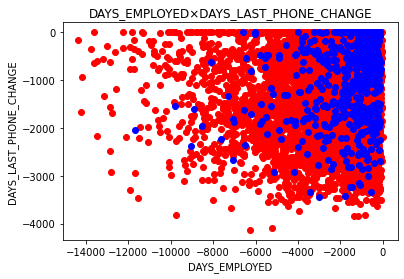

In [34]:
#・パターン３　DAYS_EMPLOYED　×　DAYS_LAST_PHONE_CHANGE

pd.options.display.float_format = '{:.0f}'.format #小数点を表示しない

#del_missing_columns_align_index["DAYS_EMPLOYED"の平均標準偏差等を表示
display(del_missing_columns_align_index["DAYS_EMPLOYED"].describe())
#del_missing_columns_align_index["DAYS_EMPLOYED"の平均標準偏差等を表示
display(del_missing_columns_align_index["DAYS_LAST_PHONE_CHANGE"].describe())

#散布図表示の（X,y）を準備する

#返済者の　DAYS_EMPLOYED×DAYS_LAST_PHONE_CHANGE
X_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'DAYS_EMPLOYED' ] ] #返済者のDAYS_EMPLOYED
y_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'DAYS_LAST_PHONE_CHANGE' ] ] #返済者のDAYS_EMPLOYED
#破産者の　DAYS_EMPLOYED×DAYS_LAST_PHONE_CHANGE
X_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'DAYS_EMPLOYED' ] ] #破産者のDAYS_EMPLOYED
y_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'DAYS_LAST_PHONE_CHANGE' ] ] #破産者のDAYS_EMPLOYED

plt.title("DAYS_EMPLOYED×DAYS_LAST_PHONE_CHANGE")
plt.xlabel("DAYS_EMPLOYED")
plt.ylabel("DAYS_LAST_PHONE_CHANGE")
plt.scatter(X_0, y_0, c='red')

plt.scatter(X_1, y_1, c='blue')
plt.show()


In [35]:
#-------------データを分割-----------

#ランダムにデータ分割するモジュール
from sklearn.model_selection import train_test_split

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 欠損値カットデータから特徴量と目的変数を取り出したDFを用意する
X = del_missing_columns_align_index.loc[ :  ,  [ 'DAYS_EMPLOYED' ,  'DAYS_LAST_PHONE_CHANGE' ] ]
y = del_missing_columns_align_index.loc[ :  ,  [ 'TARGET' ] ]


# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

display(X_train)
display(y_train)


,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE
1489,-411,0
812,-700,0
1882,-1032,-1067
6813,-120,-973
3464,-1984,-2390
...,...,...
5734,-1464,-918
5191,-1323,-1601
5390,-3508,-398
860,-1099,-715


,TARGET
1489,0
812,0
1882,0
6813,0
3464,0
...,...
5734,0
5191,0
5390,0
860,0


In [36]:
#-------------X_train, X_testを標準化する-----------

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 標準化をする（訓練用データで.fitを行う）
scaler.fit(X_train)

# 標準化をする（訓練用、検証用双方で.transformを行う）
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

display(X_train_transform)
display(X_test_transform)


array([[ 0.89940029,  1.27782371],
       [ 0.76092277,  1.27782371],
       [ 0.60184133,  0.04276232],
       ...,
       [-0.58456123,  0.81713539],
       [ 0.56973754,  0.45020525],
       [ 0.97750353,  1.27319368]])

array([[ 0.78104753,  1.18985308],
       [ 0.58459153, -0.49895159],
       [ 0.68521534, -0.15285659],
       ...,
       [ 0.81650544, -0.19799942],
       [ 0.80500558,  0.05896743],
       [ 0.91952505,  0.96761148]])

In [37]:
#-------------最近傍法（k-nearest neighbors, k-nn）による学習-----------
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighborsを決めたneighを定義する
neigh = KNeighborsClassifier(n_neighbors=3) 

#データを確認
# display(X_train_transform) #標準化した訓練用特徴量DF
# display(X_test_transform) #標準化した検証用特徴量DF
# display(y_train) #訓練用目的変数DF
# display(y_test) #検証用目的変数DF


In [38]:
#-------------検証データを代入して予測データを作成-----------

#.fitメソッドでトレーニングデータセットからk最近傍分類器を適合させる。
neigh.fit(X_train_transform, y_train)

#検証データ(X_test_transform)を引数としてクスラベル予測データを出力
y_test_pred = neigh.predict(X_test_transform) #neigh.predict(特徴量ndarray)で予測データを作成
display(y_test_pred)#予測データ

#テストデータXの確率推定値を返す。
#print(neigh.predict_proba(X_test_transform))

<ipython-input-38-092c322347db>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train_transform, y_train)


array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [39]:
#-------------最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 について
from sklearn import metrics 
print("・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について")
print("\n")

#print(y_test.shape)
#print(y_test_pred.shape)

# 評価する関数を作成する
def evaluate(y_test, y_test_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_test_pred) #正解率
    precision = metrics.precision_score(y_test, y_test_pred) #適合率
    recall = metrics.recall_score(y_test, y_test_pred) #再現率
    f1 = metrics.f1_score(y_test, y_test_pred) #F値
    confusion = metrics.confusion_matrix(y_test, y_test_pred)
    
    return acc, precision, recall, f1, confusion

acc, precision, recall, f1, confusion = evaluate(y_test, y_test_pred)
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(acc,precision,recall,f1,confusion))


・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について


acc : 0.9353788935378894
precision : 0.0
recall : 0.0
f1 : 0.0
confusion matrix 
 [[2012   20]
 [ 119    0]]


count     8602
mean     -4277
std       3082
min     -17176
25%      -6515
50%      -4001
75%      -1467
max          0
Name: DAYS_REGISTRATION, dtype: float64

count   8602
mean      11
std       12
min        0
25%        4
50%        8
75%       14
max       65
Name: OWN_CAR_AGE, dtype: float64

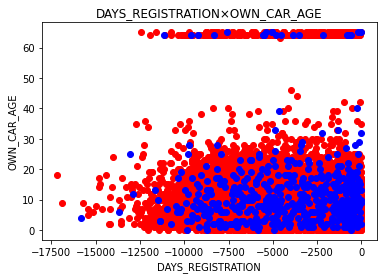

In [40]:
#・パターン４　DAYS_REGISTRATION　×　OWN_CAR_AGE

pd.options.display.float_format = '{:.0f}'.format #小数点を表示しない

#del_missing_columns_align_index["DAYS_REGISTRATION"の平均標準偏差等を表示
display(del_missing_columns_align_index["DAYS_REGISTRATION"].describe())
#del_missing_columns_align_index["OWN_CAR_AGE"の平均標準偏差等を表示
display(del_missing_columns_align_index["OWN_CAR_AGE"].describe())

#散布図表示の（X,y）を準備する

#返済者の　DAYS_REGISTRATION×OWN_CAR_AGE
X_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'DAYS_REGISTRATION' ] ] #返済者のDAYS_REGISTRATION
y_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'OWN_CAR_AGE' ] ] #返済者のOWN_CAR_AGE
#破産者の　DAYS_REGISTRATION×OWN_CAR_AGE
X_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'DAYS_REGISTRATION' ] ] #破産者のDAYS_REGISTRATION
y_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'OWN_CAR_AGE' ] ] #破産者のOWN_CAR_AGE

plt.title("DAYS_REGISTRATION×OWN_CAR_AGE")
plt.xlabel("DAYS_REGISTRATION")
plt.ylabel("OWN_CAR_AGE")
plt.scatter(X_0, y_0, c='red')

plt.scatter(X_1, y_1, c='blue')
plt.show()


In [41]:
#-------------データを分割-----------

#ランダムにデータ分割するモジュール
from sklearn.model_selection import train_test_split

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 欠損値カットデータから特徴量と目的変数を取り出したDFを用意する
X = del_missing_columns_align_index.loc[ :  ,  [ 'DAYS_REGISTRATION' ,  'OWN_CAR_AGE' ] ]
y = del_missing_columns_align_index.loc[ :  ,  [ 'TARGET' ] ]


# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

display(X_train)
display(y_train)


,DAYS_REGISTRATION,OWN_CAR_AGE
1489,-7493,0
812,-9040,38
1882,-1214,4
6813,-149,14
3464,-7215,14
...,...,...
5734,-4381,4
5191,-1686,2
5390,-7508,12
860,-1101,14


,TARGET
1489,0
812,0
1882,0
6813,0
3464,0
...,...
5734,0
5191,0
5390,0
860,0


In [42]:
#-------------X_train, X_testを標準化する-----------

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 標準化をする（訓練用データで.fitを行う）
scaler.fit(X_train)

# 標準化をする（訓練用、検証用双方で.transformを行う）
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

display(X_train_transform)
display(X_test_transform)



array([[-1.03703388, -0.89817879],
       [-1.53657745,  2.15865678],
       [ 0.99052531, -0.57640663],
       ...,
       [-1.04187755,  0.0671377 ],
       [ 1.02701428,  0.22802379],
       [-1.76616729,  0.71068204]])

array([[-1.26920701, -0.3350775 ],
       [ 1.14164774, -0.17419142],
       [-1.83623901,  0.14758075],
       ...,
       [-0.37312853, -0.17419142],
       [-1.41774614,  0.54979595],
       [ 1.30730116,  0.30846683]])

In [43]:
#-------------最近傍法（k-nearest neighbors, k-nn）による学習-----------
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighborsを決めたneighを定義する
neigh = KNeighborsClassifier(n_neighbors=3) 

#データを確認
# display(X_train_transform) #標準化した訓練用特徴量DF
# display(X_test_transform) #標準化した検証用特徴量DF
# display(y_train) #訓練用目的変数DF
# display(y_test) #検証用目的変数DF

In [44]:
#-------------検証データを代入して予測データを作成-----------

#.fitメソッドでトレーニングデータセットからk最近傍分類器を適合させる。
neigh.fit(X_train_transform, y_train)

#検証データ(X_test_transform)を引数としてクスラベル予測データを出力
y_test_pred = neigh.predict(X_test_transform) #neigh.predict(特徴量ndarray)で予測データを作成
display(y_test_pred)#予測データ

#テストデータXの確率推定値を返す。
#print(neigh.predict_proba(X_test_transform))

<ipython-input-44-092c322347db>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train_transform, y_train)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [45]:
#-------------最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 について
from sklearn import metrics 
print("・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について")
print("\n")

#print(y_test.shape)
#print(y_test_pred.shape)

# 評価する関数を作成する
def evaluate(y_test, y_test_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_test_pred) #正解率
    precision = metrics.precision_score(y_test, y_test_pred) #適合率
    recall = metrics.recall_score(y_test, y_test_pred) #再現率
    f1 = metrics.f1_score(y_test, y_test_pred) #F値
    confusion = metrics.confusion_matrix(y_test, y_test_pred)
    
    return acc, precision, recall, f1, confusion

acc, precision, recall, f1, confusion = evaluate(y_test, y_test_pred)
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(acc,precision,recall,f1,confusion))


・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について


acc : 0.9330543933054394
precision : 0.0967741935483871
recall : 0.025210084033613446
f1 : 0.04000000000000001
confusion matrix 
 [[2004   28]
 [ 116    3]]


count   8602
mean      11
std       12
min        0
25%        4
50%        8
75%       14
max       65
Name: OWN_CAR_AGE, dtype: float64

count    8602
mean    -1109
std       866
min     -4131
25%     -1736
50%      -967
75%      -389
max         0
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

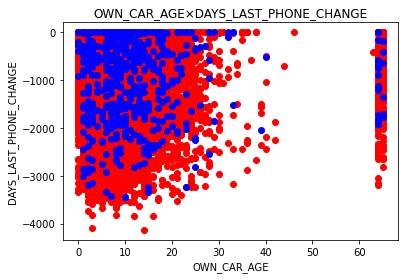

In [46]:
#・パターン５　OWN_CAR_AGE　×　DAYS_LAST_PHONE_CHANGE

pd.options.display.float_format = '{:.0f}'.format #小数点を表示しない

#del_missing_columns_align_index["OWN_CAR_AGE"の平均標準偏差等を表示
display(del_missing_columns_align_index["OWN_CAR_AGE"].describe())
#del_missing_columns_align_index["DAYS_LAST_PHONE_CHANGEの平均標準偏差等を表示
display(del_missing_columns_align_index["DAYS_LAST_PHONE_CHANGE"].describe())

#散布図表示の（X,y）を準備する

#返済者の　OWN_CAR_AGE×DAYS_LAST_PHONE_CHANGE
X_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'OWN_CAR_AGE' ] ] #返済者のOWN_CAR_AGE
y_0 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==0].loc[ :  ,  [ 'DAYS_LAST_PHONE_CHANGE' ] ] #返済者のDAYS_LAST_PHONE_CHANGE
#破産者の　OWN_CAR_AGE×DAYS_LAST_PHONE_CHANGE
X_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'OWN_CAR_AGE' ] ] #破産者のOWN_CAR_AGE
y_1 = del_missing_columns_align_index[del_missing_columns_align_index.TARGET==1].loc[ :  ,  [ 'DAYS_LAST_PHONE_CHANGE' ] ] #破産者のDAYS_LAST_PHONE_CHANGE

plt.title("OWN_CAR_AGE×DAYS_LAST_PHONE_CHANGE")
plt.xlabel("OWN_CAR_AGE")
plt.ylabel("DAYS_LAST_PHONE_CHANGE")
plt.scatter(X_0, y_0, c='red')

plt.scatter(X_1, y_1, c='blue')
plt.show()





In [47]:
#-------------データを分割-----------

#ランダムにデータ分割するモジュール
from sklearn.model_selection import train_test_split

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 欠損値カットデータから特徴量と目的変数を取り出したDFを用意する
X = del_missing_columns_align_index.loc[ :  ,  [ 'OWN_CAR_AGE' ,  'DAYS_LAST_PHONE_CHANGE' ] ]
y = del_missing_columns_align_index.loc[ :  ,  [ 'TARGET' ] ]


# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

display(X_train)
display(y_train)



,OWN_CAR_AGE,DAYS_LAST_PHONE_CHANGE
1489,0,0
812,38,0
1882,4,-1067
6813,14,-973
3464,14,-2390
...,...,...
5734,4,-918
5191,2,-1601
5390,12,-398
860,14,-715


,TARGET
1489,0
812,0
1882,0
6813,0
3464,0
...,...
5734,0
5191,0
5390,0
860,0


In [48]:
#-------------X_train, X_testを標準化する-----------

# sklearnから標準化をするモデルをインポートする
from sklearn.preprocessing import StandardScaler

# モデルをインスタンス化して、モデルの中にあるメソッドを使える状態にする。
scaler = StandardScaler()

# 標準化をする（訓練用データで.fitを行う）
scaler.fit(X_train)

# 標準化をする（訓練用、検証用双方で.transformを行う）
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

display(X_train_transform)
display(X_test_transform)

array([[-0.89817879,  1.27782371],
       [ 2.15865678,  1.27782371],
       [-0.57640663,  0.04276232],
       ...,
       [ 0.0671377 ,  0.81713539],
       [ 0.22802379,  0.45020525],
       [ 0.71068204,  1.27319368]])

array([[-0.3350775 ,  1.18985308],
       [-0.17419142, -0.49895159],
       [ 0.14758075, -0.15285659],
       ...,
       [-0.17419142, -0.19799942],
       [ 0.54979595,  0.05896743],
       [ 0.30846683,  0.96761148]])

In [49]:
#-------------最近傍法（k-nearest neighbors, k-nn）による学習-----------
from sklearn.neighbors import KNeighborsClassifier

#パラメータn_neighborsを決めたneighを定義する
neigh = KNeighborsClassifier(n_neighbors=3) 

#データを確認
# display(X_train_transform) #標準化した訓練用特徴量DF
# display(X_test_transform) #標準化した検証用特徴量DF
# display(y_train) #訓練用目的変数DF
# display(y_test) #検証用目的変数DF

In [50]:
#-------------検証データを代入して予測データを作成-----------

#.fitメソッドでトレーニングデータセットからk最近傍分類器を適合させる。
neigh.fit(X_train_transform, y_train)

#検証データ(X_test_transform)を引数としてクスラベル予測データを出力
y_test_pred = neigh.predict(X_test_transform) #neigh.predict(特徴量ndarray)で予測データを作成
display(y_test_pred)#予測データ

#テストデータXの確率推定値を返す。
#print(neigh.predict_proba(X_test_transform))


<ipython-input-50-092c322347db>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh.fit(X_train_transform, y_train)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [51]:
#-------------最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値 について
from sklearn import metrics 
print("・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について")
print("\n")

#print(y_test.shape)
#print(y_test_pred.shape)

# 評価する関数を作成する
def evaluate(y_test, y_test_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_test_pred) #正解率
    precision = metrics.precision_score(y_test, y_test_pred) #適合率
    recall = metrics.recall_score(y_test, y_test_pred) #再現率
    f1 = metrics.f1_score(y_test, y_test_pred) #F値
    confusion = metrics.confusion_matrix(y_test, y_test_pred)
    
    return acc, precision, recall, f1, confusion

acc, precision, recall, f1, confusion = evaluate(y_test, y_test_pred)
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(acc,precision,recall,f1,confusion))


・最近傍法のAccuracy（正解率）、Precision（適合率）、Recall（再現率）、F値について


acc : 0.9284053928405392
precision : 0.02702702702702703
recall : 0.008403361344537815
f1 : 0.01282051282051282
confusion matrix 
 [[1996   36]
 [ 118    1]]


下記の通り検証した結果をまとめて

一番結果が良かったのが
・DAYS_EMPLOYED　×　DAYS_LAST_PHONE_CHANGE
で悪かったのが
・OWN_CAR_AGE　×　DAYS_LAST_PHONE_CHANGE

でした。

#・パターン１　AMT_INCOME_TOTAL　×　DAYS_BIRTH

acc : 0.9311947931194793

precision : 0.0

recall : 0.0

f1 : 0.0

confusion matrix 
 [[2003   29] 
 [ 119    0]]

#・パターン２　OWN_CAR_AGE　×　DAYS_EMPLOYED

acc : 0.9293351929335193

precision : 0.05405405405405406

recall : 0.01680672268907563

f1 : 0.02564102564102564

confusion matrix 
 [[1997   35]
 [ 117    2]]

#・パターン３　DAYS_EMPLOYED　×　DAYS_LAST_PHONE_CHANGE

acc : 0.9353788935378894

precision : 0.0

recall : 0.0

f1 : 0.0

confusion matrix 
 [[2012   20]
 [ 119    0]]

#・パターン４　DAYS_REGISTRATION　×　OWN_CAR_AGE

acc : 0.9330543933054394

precision : 0.0967741935483871

recall : 0.025210084033613446

f1 : 0.04000000000000001

confusion matrix 
 [[2004   28]
 [ 116    3]]

#・パターン５　OWN_CAR_AGE　×　DAYS_LAST_PHONE_CHANGE

acc : 0.9284053928405392

precision : 0.02702702702702703

recall : 0.008403361344537815

f1 : 0.01282051282051282

confusion matrix 
 [[1996   36]
 [ 118    1]]